<a href="https://colab.research.google.com/github/kosmasrio0411/PCD_Assignment03/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tugas 3 Pengolahan Citra Digital
##Nama: Kosmas Rio Legowo
##NIM: 23/512012/PA/21863

##1) Tujuan
Membandingkan hasil segmentasi awal (thresholding/Otsu saja) dengan hasil setelah morphological processing
(erosion, dilation, opening, closing, thinning, thickening) untuk menilai dampak pembersihan noise, perbaikan kontur,
dan keutuhan objek.


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 2) Otsu Thresholding
Citra biner mentah (hasil segmentasi) umumnya masih:
- Mengandung noise kecil pada latar.
- Memiliki lubang/celah di dalam objek (karena variasi intensitas).
- Kontur bergerigi atau tepi putus-putus.
- Bisa menempel antar-objek atau malah terpecah (under/over-segmentation).


In [15]:
def otsu_threshold(img):
    pixel_counts, _ = np.histogram(img, bins=256, range=(0, 256))
    total = img.size
    current_max, threshold = 0, 0
    sum_total = np.dot(np.arange(256), pixel_counts)
    sum_foreground, weight_background = 0, 0

    for i in range(256):
        weight_background += pixel_counts[i]
        if weight_background == 0:
            continue
        weight_foreground = total - weight_background
        if weight_foreground == 0:
            break
        sum_foreground += i * pixel_counts[i]
        mean_back = sum_foreground / weight_background
        mean_fore = (sum_total - sum_foreground) / weight_foreground
        between_var = weight_background * weight_foreground * (mean_back - mean_fore) ** 2
        if between_var > current_max:
            current_max = between_var
            threshold = i
    return threshold


## 3) Morphological Processing
Menggunakan structuring element (SE) yang sesuai bentuk objek (mis. cross/square/disk) dan ukuran proporsional.

- Erosion (eroded): mengecilkan area foreground; membersihkan serabut tipis di tepi.
- Dilation (dilated): memperbesar area foreground; menutup gap kecil/putus.
- Opening (opened = erosion->dilation): menghapus noise tanpa banyak merusak bentuk utama.
- Closing (closed = dilation->erosion): menutup lubang kecil di dalam objek agar objek solid/padu.
- Thinning (thin_img): menipiskan garis -> bermanfaat untuk skeleton/analisis bentuk.
- Thickening (thick_img): mempertebal struktur tipis -> memperkuat kontur/isi objek.

In [16]:
def pad_image(img, se, mode='edge'):
    m, n = se.shape
    py, px = m // 2, n // 2
    if mode == 'constant':
        return np.pad(img, ((py, py), (px, px)), mode='constant', constant_values=0)
    else:
        return np.pad(img, ((py, py), (px, px)), mode=mode)

def erosion(img, se, pad_mode='edge'):
    m, n = se.shape
    py, px = m // 2, n // 2
    padded = pad_image(img, se, mode=pad_mode)
    result = np.zeros_like(img)

    # indeks di 'padded' disejajarkan dengan ukuran asli
    for i in range(py, py + img.shape[0]):
        for j in range(px, px + img.shape[1]):
            region = padded[i - py:i + py + 1, j - px:j + px + 1]
            if np.all(region[se == 1] == 1):
                result[i - py, j - px] = 1
    return result

def dilation(img, se, pad_mode='edge'):
    m, n = se.shape
    py, px = m // 2, n // 2
    padded = pad_image(img, se, mode=pad_mode)
    result = np.zeros_like(img)

    for i in range(py, py + img.shape[0]):
        for j in range(px, px + img.shape[1]):
            region = padded[i - py:i + py + 1, j - px:j + px + 1]
            if np.any(region[se == 1] == 1):
                result[i - py, j - px] = 1
    return result

def opening(img, se, pad_mode='edge'):
    return dilation(erosion(img, se, pad_mode), se, pad_mode)

def closing(img, se, pad_mode='edge'):
    return erosion(dilation(img, se, pad_mode), se, pad_mode)


In [17]:
def hit_and_miss(img, B1, B2):
    eroded1 = erosion(img, B1)
    eroded2 = erosion(1 - img, B2)
    return np.logical_and(eroded1, eroded2).astype(np.uint8)

def thinning(img, se):
    hitmiss = hit_and_miss(img, se, 1 - se)
    return np.logical_and(img, np.logical_not(hitmiss)).astype(np.uint8)

def thickening(img, se):
    hitmiss = hit_and_miss(img, se, 1 - se)
    return np.logical_or(img, hitmiss).astype(np.uint8)


## 4) Pemilihan Structuring Element (SE)
- Disk (lingkaran) → halus/isotropik; cocok objek organik (buah, sel).
- Cross → menjaga struktur ortogonal; tidak menyatukan diagonal.
- Square → agresif/cepat; efektif untuk noise besar namun bisa memperkenalkan sudut “kotak”.
- Semakin besar SE → efek makin kuat (lebih bersih) tapi risiko hilang detail meningkat.

Di bawah ini adalah eksperimen dengan SE Cross

In [18]:
B = np.array([[0,1,0],
              [1,1,1],
              [0,1,0]], dtype=np.uint8)

Otsu threshold = 200


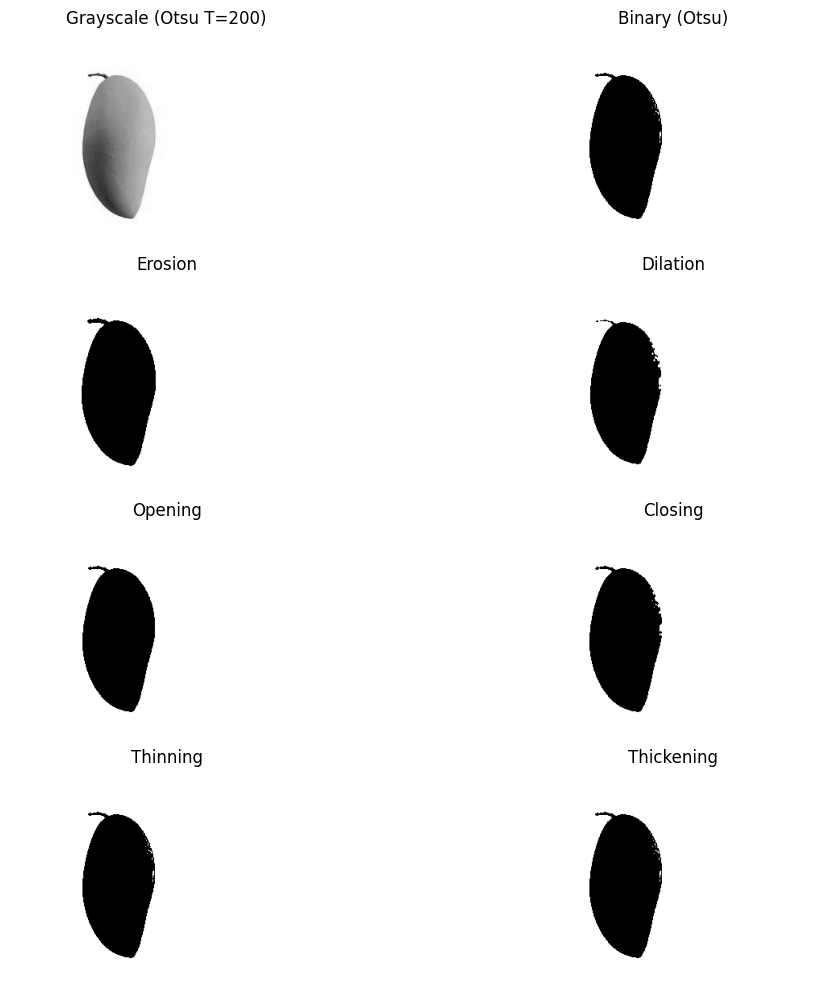

In [19]:
img = cv2.imread('mango.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T = otsu_threshold(gray)
binary = np.where(gray >= T, 1, 0).astype(np.uint8)
print(f"Otsu threshold = {T}")

eroded = erosion(binary, B)
dilated = dilation(binary, B)
opened = opening(binary, B)
closed = closing(binary, B)

thin_img = thinning(binary, B)
thick_img = thickening(binary, B)
titles = [
    f'Grayscale (Otsu T={T})', 'Binary (Otsu)',
    'Erosion', 'Dilation', 'Opening', 'Closing',
    'Thinning', 'Thickening'
]
images = [gray, binary, eroded, dilated, opened, closed, thin_img, thick_img]

plt.figure(figsize=(12, 10))
for i in range(len(images)):
    plt.subplot(4, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Otsu threshold = 178


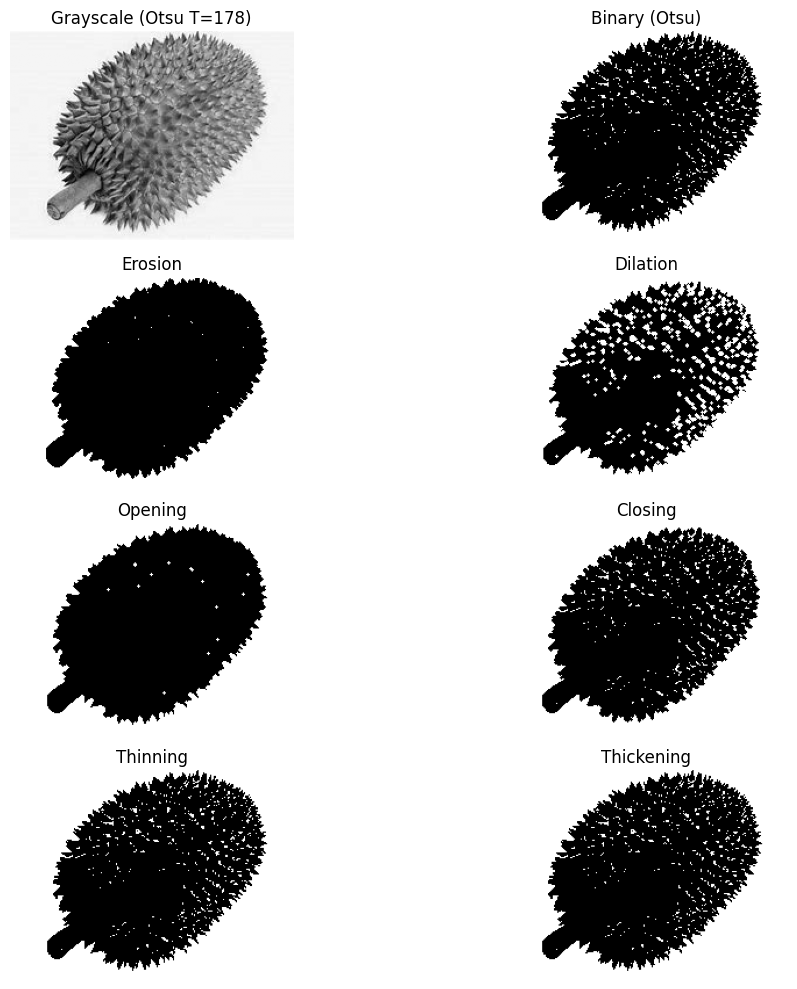

In [20]:
img = cv2.imread('durian.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T = otsu_threshold(gray)
binary = np.where(gray >= T, 1, 0).astype(np.uint8)
print(f"Otsu threshold = {T}")

eroded = erosion(binary, B)
dilated = dilation(binary, B)
opened = opening(binary, B)
closed = closing(binary, B)

thin_img = thinning(binary, B)
thick_img = thickening(binary, B)
titles = [
    f'Grayscale (Otsu T={T})', 'Binary (Otsu)',
    'Erosion', 'Dilation', 'Opening', 'Closing',
    'Thinning', 'Thickening'
]
images = [gray, binary, eroded, dilated, opened, closed, thin_img, thick_img]

plt.figure(figsize=(12, 10))
for i in range(len(images)):
    plt.subplot(4, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Otsu threshold = 154


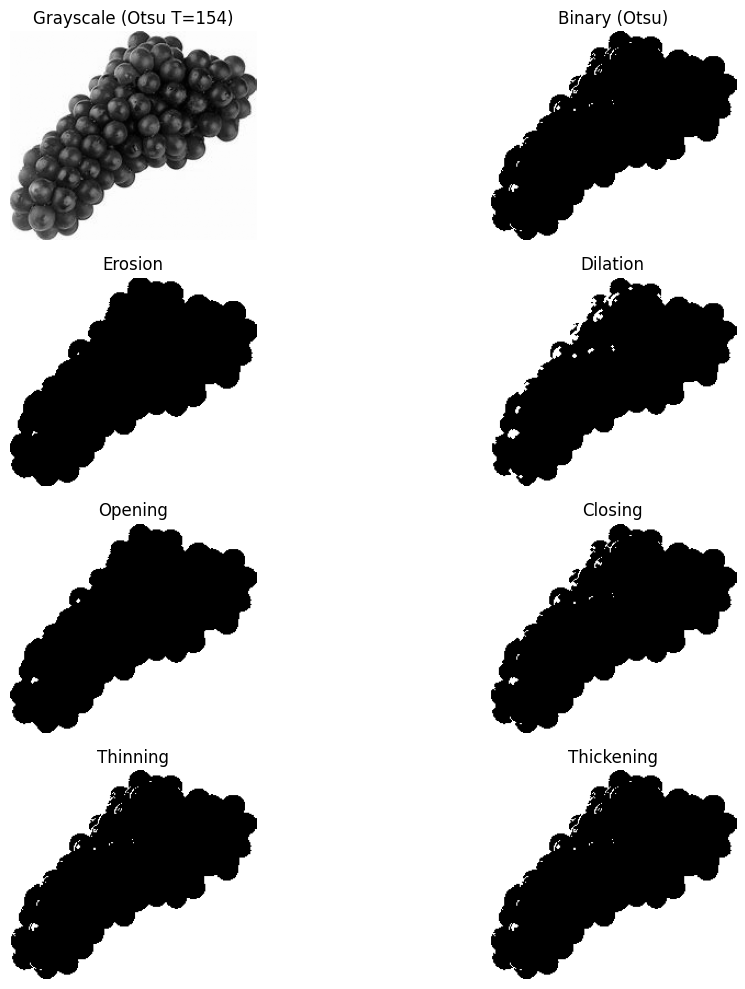

In [21]:
img = cv2.imread('grape.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T = otsu_threshold(gray)
binary = np.where(gray >= T, 1, 0).astype(np.uint8)
print(f"Otsu threshold = {T}")

eroded = erosion(binary, B)
dilated = dilation(binary, B)
opened = opening(binary, B)
closed = closing(binary, B)

thin_img = thinning(binary, B)
thick_img = thickening(binary, B)

titles = [
    f'Grayscale (Otsu T={T})', 'Binary (Otsu)',
    'Erosion', 'Dilation', 'Opening', 'Closing',
    'Thinning', 'Thickening'
]
images = [gray, binary, eroded, dilated, opened, closed, thin_img, thick_img]

plt.figure(figsize=(12, 10))
for i in range(len(images)):
    plt.subplot(4, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


##5) Eksperimen dengan SE lain
Di bawah ini adalah eksperimen dengan SE Disk

In [26]:
# contoh SE disk radius 3
def circular_se(r):
    y, x = np.ogrid[-r:r+1, -r:r+1]
    return ((x*x + y*y) <= r*r).astype(np.uint8)

B = circular_se(3)


Otsu threshold = 200


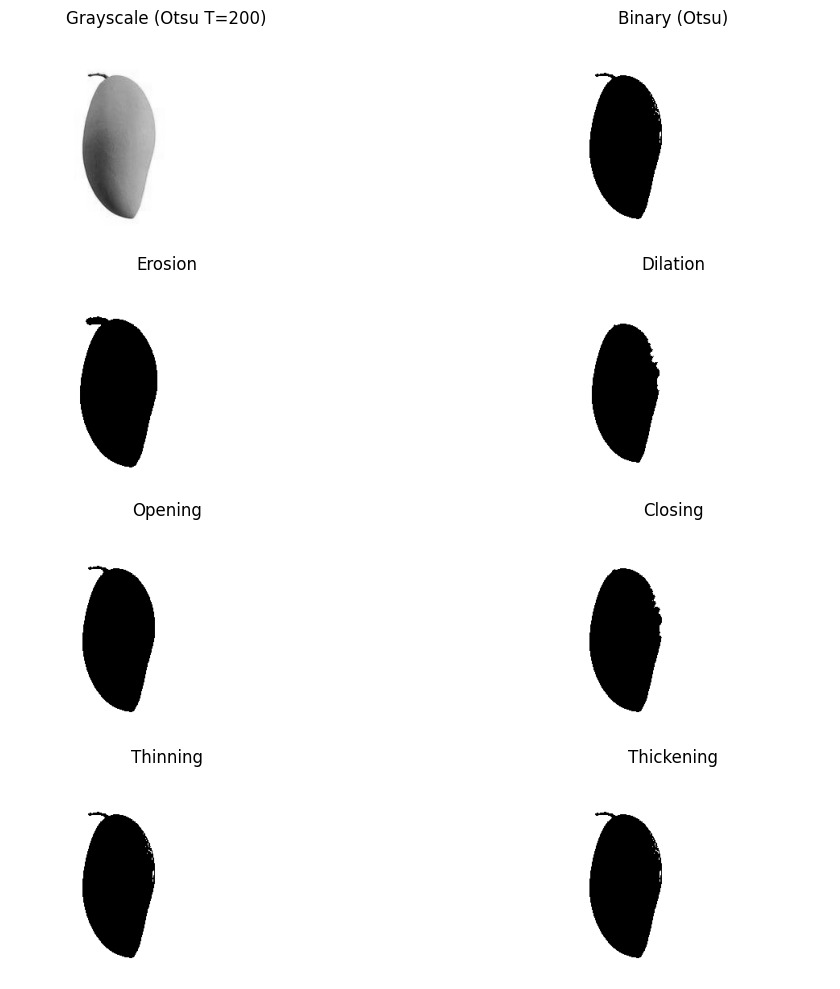

In [27]:
img = cv2.imread('mango.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T = otsu_threshold(gray)
binary = np.where(gray >= T, 1, 0).astype(np.uint8)
print(f"Otsu threshold = {T}")

eroded = erosion(binary, B)
dilated = dilation(binary, B)
opened = opening(binary, B)
closed = closing(binary, B)

thin_img = thinning(binary, B)
thick_img = thickening(binary, B)
titles = [
    f'Grayscale (Otsu T={T})', 'Binary (Otsu)',
    'Erosion', 'Dilation', 'Opening', 'Closing',
    'Thinning', 'Thickening'
]
images = [gray, binary, eroded, dilated, opened, closed, thin_img, thick_img]

plt.figure(figsize=(12, 10))
for i in range(len(images)):
    plt.subplot(4, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Otsu threshold = 178


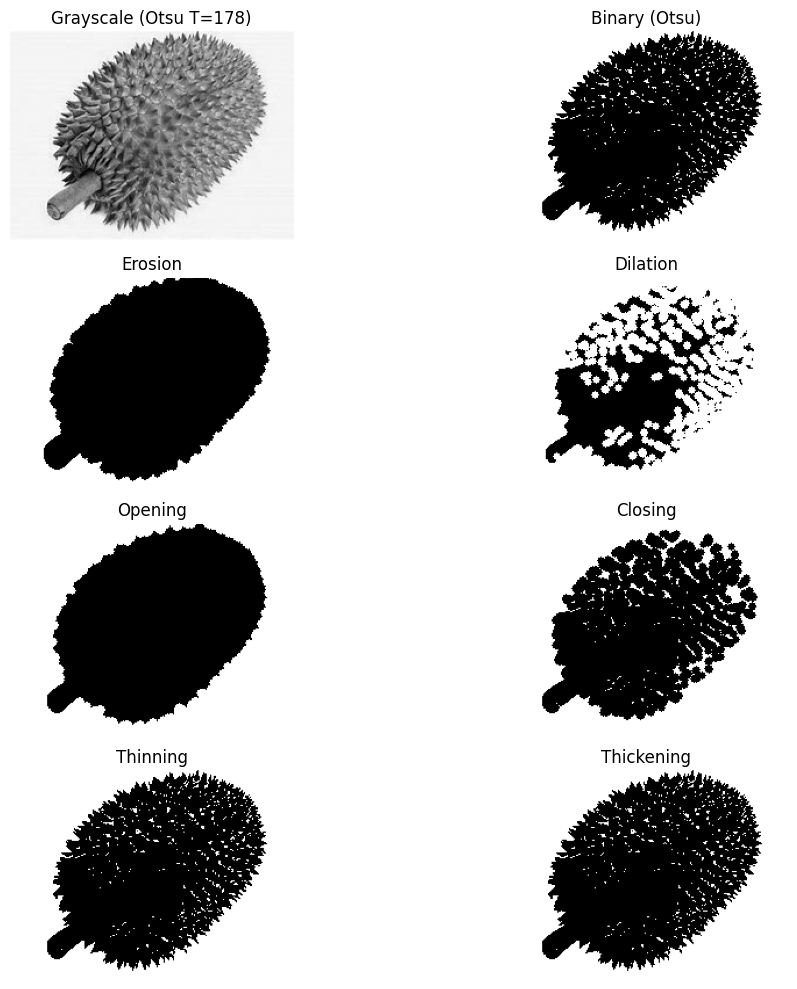

In [28]:
img = cv2.imread('durian.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T = otsu_threshold(gray)
binary = np.where(gray >= T, 1, 0).astype(np.uint8)
print(f"Otsu threshold = {T}")

eroded = erosion(binary, B)
dilated = dilation(binary, B)
opened = opening(binary, B)
closed = closing(binary, B)

thin_img = thinning(binary, B)
thick_img = thickening(binary, B)
titles = [
    f'Grayscale (Otsu T={T})', 'Binary (Otsu)',
    'Erosion', 'Dilation', 'Opening', 'Closing',
    'Thinning', 'Thickening'
]
images = [gray, binary, eroded, dilated, opened, closed, thin_img, thick_img]

plt.figure(figsize=(12, 10))
for i in range(len(images)):
    plt.subplot(4, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Otsu threshold = 154


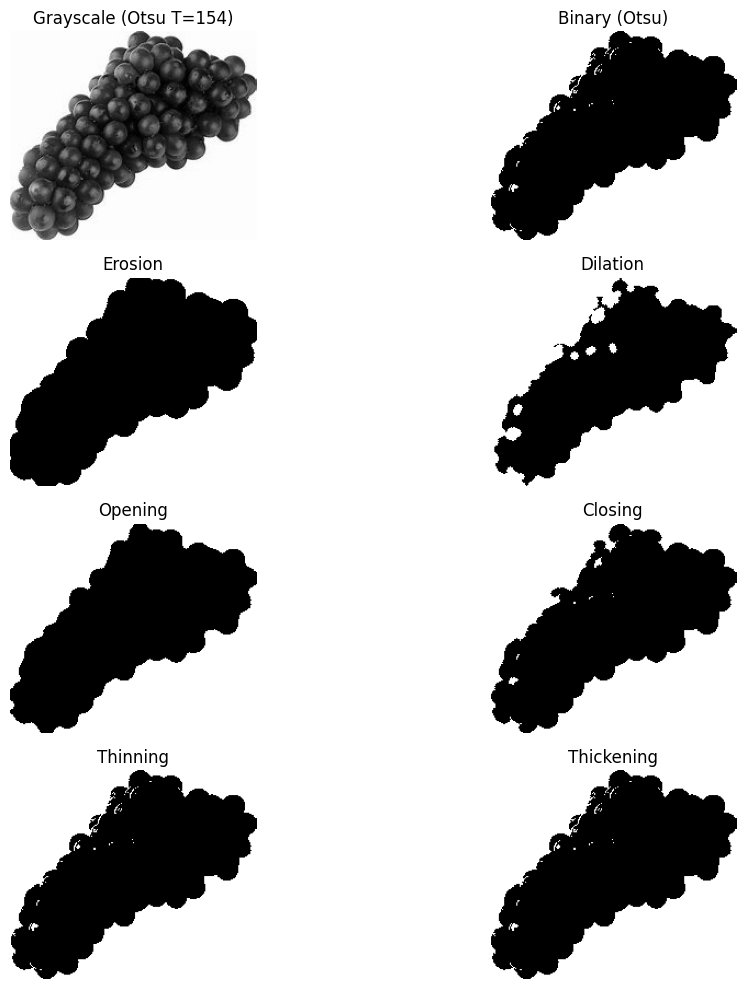

In [29]:
img = cv2.imread('grape.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T = otsu_threshold(gray)
binary = np.where(gray >= T, 1, 0).astype(np.uint8)
print(f"Otsu threshold = {T}")

eroded = erosion(binary, B)
dilated = dilation(binary, B)
opened = opening(binary, B)
closed = closing(binary, B)

thin_img = thinning(binary, B)
thick_img = thickening(binary, B)

titles = [
    f'Grayscale (Otsu T={T})', 'Binary (Otsu)',
    'Erosion', 'Dilation', 'Opening', 'Closing',
    'Thinning', 'Thickening'
]
images = [gray, binary, eroded, dilated, opened, closed, thin_img, thick_img]

plt.figure(figsize=(12, 10))
for i in range(len(images)):
    plt.subplot(4, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


##6) Kesimpulan

* Morphological processing secara signifikan meningkatkan hasil segmentasi.
  Operasi seperti opening dan closing membuat citra lebih bersih, menghapus noise kecil, menutup lubang, dan memperhalus kontur objek.

* Pipeline simple dan efektif:
  Kombinasi binary -> opening -> closing memberikan hasil yang stabil tanpa merusak bentuk utama objek.

* Pemilihan operasi dan structuring element (SE) sangat penting.
  Jenis SE menentukan arah dan kekuatan perubahan bentuk:

  * Disk (lingkaran) menjaga bentuk alami dan halus.
  * Square agresif, cocok untuk noise besar.
  * Cross menjaga garis dan struktur ortogonal.
    
    Ukuran SE menentukan seberapa kuat efek cleaning besar untuk noise banyak, kecil untuk mempertahankan detail.

* Alasan pentingnya pemilihan SE dan operasi morfologi:

  Karena hasil segmentasi bukan hanya soal pemisahan warna (threshold), tetapi juga soal ketepatan bentuk dan keutuhan objek.
  Dengan kombinasi operasi dan SE yang sesuai, hasil segmentasi menjadi lebih akurat, stabil, dan siap untuk tahap analisis lanjutan seperti pengukuran area atau pengenalan bentuk.
